In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

#Reference Ephemeris of BQ Ari:
P=0.282335 
t0=2458043.4658  


In [3]:
#importing mid-eclipse times as t and their errors as yerr
data = ascii.read('Path of data')
t= data['col1']
yerr = data['col2']*1440 #1440 is the number of minutes in day

Least-squares estimates:
m_ls = 0.00006841 ± 0.00003037
b_ls = -2.17097998 ± 0.08282334


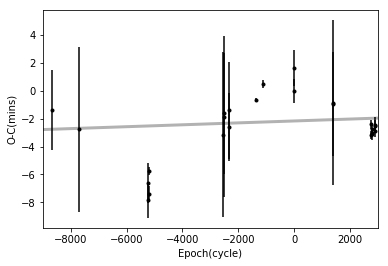

In [4]:
#calculatingepoch as x & oc as y 
x=np.round((t-t0)/P*2)/2          
tC=t0+P*x
y=(t-tC)*1440


#
x0 = np.linspace(-9000, 3000, 500)
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m_ls = {0:.8f} ± {1:.8f}".format(w[0], np.sqrt(cov[0, 0])))
print("b_ls = {0:.8f} ± {1:.8f}".format(w[1], np.sqrt(cov[1, 1])))
m_ls=w[0]
b_ls=w[1]


plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(-9000, 3000, 500)
plt.plot(x0, m_ls * x0 + b_ls, "k", alpha=0.3, lw=3)
plt.xlim(-9000, 3000)
plt.xlabel("Epoch(cycle)")
plt.ylabel("O-C(mins)");


In [5]:

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    
    

Maximum likelihood estimates:
dP = 0.00026349
dT = -2.82472858


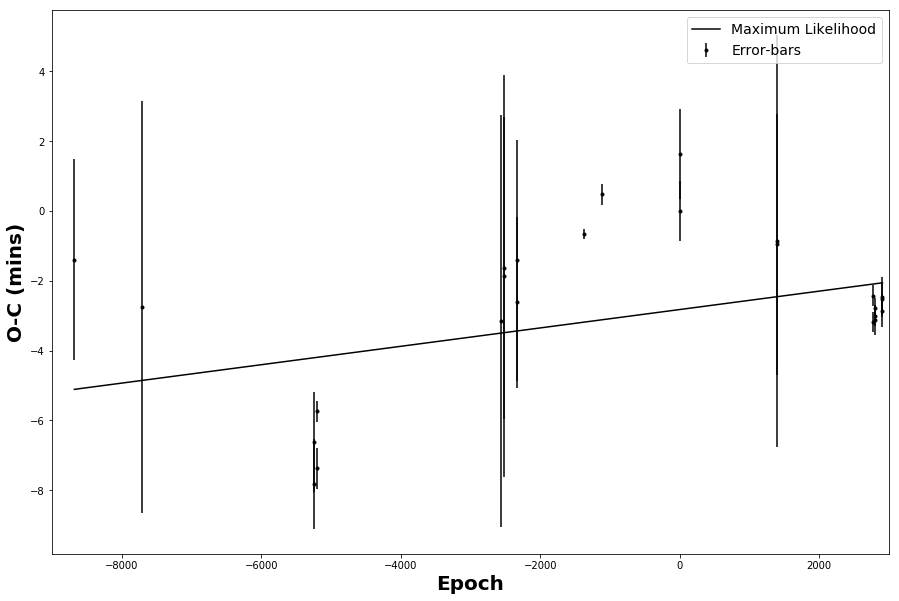

In [6]:
f_true = 0.47

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_ls, b_ls, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("dP = {0:.8f}".format(m_ml))
print("dT = {0:.8f}".format(b_ml))





#Plot TTV diagram
plt.rcParams['figure.figsize'] = (15,10)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0,label="Error-bars")
#plt.plot(x, m_ls * x + b_ls, "--k",  label="Least Squares")
plt.plot(x, m_ml * x + b_ml, "k", label="Maximum Likelihood")
plt.legend(fontsize=14)
plt.xlim(-9000, 3000)
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.xlabel("Epoch",fontsize=20, fontweight='bold')
plt.ylabel("O-C (mins)",fontsize=20, fontweight='bold');



In [7]:
def log_prior(theta):
    m, b, log_f = theta
    if -10< m < 10 and -10 < b < 10 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf



def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
    
    

100%|██████████| 10000/10000 [01:20<00:00, 123.55it/s]


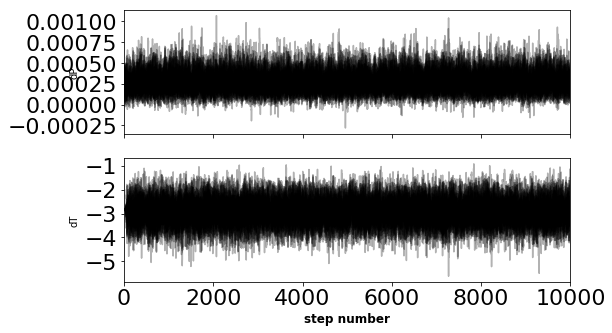

In [8]:
import emcee
nwalkers=100


pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 10000, progress=True)



fig, axes = plt.subplots(2, figsize=(8, 5), sharex=True)
samples = sampler.get_chain()
labels = ["dP", "dT"]

for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples),)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number",fontsize=12, fontweight='bold')
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8)

[39.46487134 41.41056122 38.79913208]
(31680, 3)


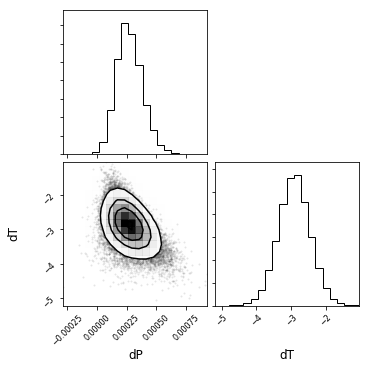

In [9]:
tau = sampler.get_autocorr_time()
print(tau)


flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
print(flat_samples.shape)



#corner plot
import corner


fig = corner.corner(flat_samples[:,:2],bins=20, labels=labels,label_kwargs={"fontsize": 12}, unit_kwargs={"fontsize":3}, smooth=True)

import matplotlib 
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 


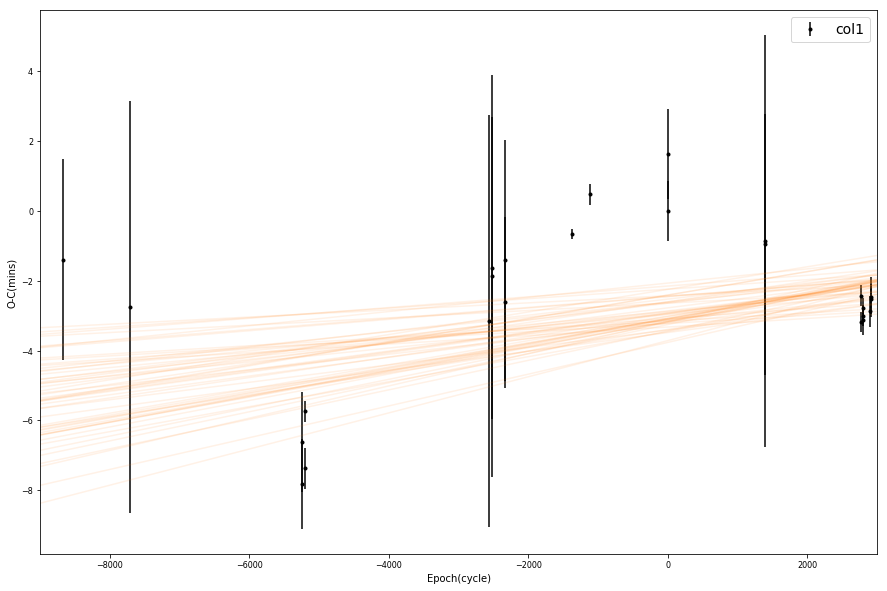

In [10]:
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x, m_ls * x + b_ls, "k",  label="Least Squares")
#plt.plot(x, m_ml * x + b_ml, ":k", label="Maximum Likelihood")
plt.legend(fontsize=14)
plt.xlim(-9000, 3000)
plt.xlabel("Epoch(cycle)")
plt.ylabel("O-C(mins)");



In [11]:
from IPython.display import display, Math

for i in range(ndim-1):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.8f}}}^{{{2:.8f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt)) 
    
    


<IPython.core.display.Math object>

<IPython.core.display.Math object>

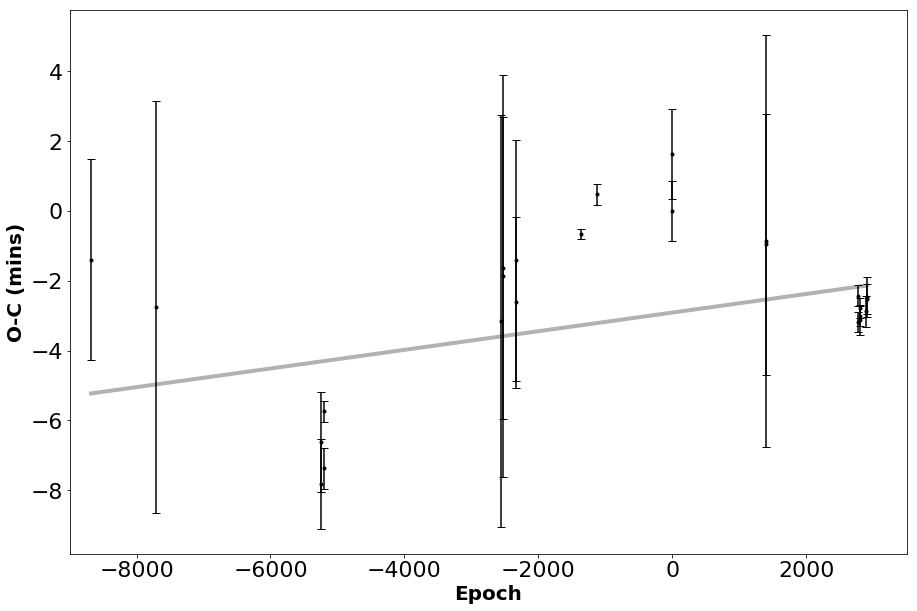

In [29]:

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=4)

plt.plot(x,0.00026694 * x - 2.91234494, "k", alpha=0.3, lw=4)
plt.xlim(-9000, 3500)
plt.xlabel("Epoch",fontsize=20, fontweight='bold')
plt.ylabel("O-C (mins)",fontsize=20, fontweight='bold'); 



